In [150]:
import numpy as np
import scipy.optimize
import pandas as pd
import operator
import scipy.io
import scipy
import scipy.sparse
import time
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pandas as pd

In [3]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'mmort')))
import experiments
import optimization_tools
import evaluation
import utils

In [4]:
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'ProstateExample_BODY_not_reduced_with_OAR_constraints.mat'))
# data_no_body_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'ProstateExample.mat'))
data = scipy.io.loadmat(data_path)
# data_no_body =  scipy.io.loadmat(data_no_body_path)
Alpha = np.array([0.35, 0.35])
Beta = np.array([0.175, 0.175])
Gamma = np.array([np.array([0.35, 0.35]),
                  np.array([0.35, 0.35]),
                  np.array([0.35, 0.35]),
                  np.array([0.35, 0.35]),
                  np.array([0.35, 0.35])               
                 ])
Delta = np.array([np.array([0.07, 0.07]),
                  np.array([0.07, 0.07]),
                  np.array([0.175, 0.175]),
                  np.array([0.175, 0.175]),
                  np.array([0.175, 0.175])                
                 ])
modality_names = np.array(['Aphoton', 'Aproton'])

num_body_voxels = 683189
data['Aphoton'][-1] = data['Aphoton'][-1]/num_body_voxels
data['Aproton'][-1] = data['Aproton'][-1]/num_body_voxels

In [5]:
#Max dose for dv constrained organs:
import copy

data_max_dose = copy.deepcopy(data)
data_max_dose['OAR_constraint_types'][data_max_dose['OAR_constraint_types'] == 'dose_volume'] = 'max_dose'
data_max_dose

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar  1 01:37:10 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Aproton': <32061x16358 sparse matrix of type '<class 'numpy.float64'>'
 	with 16735951 stored elements in Compressed Sparse Column format>,
 'Organ': array([[array(['Target'], dtype='<U6'), array(['Rectum'], dtype='<U6'),
         array(['Bladder'], dtype='<U7'), array(['R Femur'], dtype='<U7'),
         array(['L Femur'], dtype='<U7'), array(['BODY'], dtype='<U4')]],
       dtype=object),
 'beamlet_pos': array([[-70.,  15.],
        [-70.,  20.],
        [-70.,  25.],
        ...,
        [ 50.,  20.],
        [ 50.,  25.],
        [ 50.,  30.]]),
 'maxAreducedphoton': <30207x2289 sparse matrix of type '<class 'numpy.float64'>'
 	with 16478507 stored elements in Compressed Sparse Column format>,
 'num_beamlets': array([[480, 405, 497, 493, 414]], dtype=uint16),
 'num_voxels': array([[ 6782,  1773, 11595,  5958,  5952,     1]]),
 'maxAreducedproton':

In [11]:
T_list_conv_max = utils.load_obj('T_list_conv_max_upd')
T_conv_max = utils.load_obj('T_conv_max_upd')
updated_H_conv = utils.load_obj('H_conv_max_upd')
alpha_conv_max = utils.load_obj('alpha_conv_max_upd')
updated_gamma_conv = utils.load_obj('gamma_conv_max_upd')
B_conv_max = utils.load_obj('B_conv_max_upd')
updated_D_conv = utils.load_obj('D_conv_max_upd')
updated_C_conv = utils.load_obj('C_conv_max_upd')

u_mult_dv = utils.load_obj('u_mult_dv')

In [12]:
T_list_mult_max = utils.load_obj('T_list_mult_max_upd')
T_mult_max = utils.load_obj('T_mult_max_upd')
updated_H = utils.load_obj('H_mult_max_upd')
alpha_mult_max = utils.load_obj('alpha_mult_max_upd')
updated_gamma = utils.load_obj('gamma_mult_max_upd')
B_mult_max = utils.load_obj('B_mult_max_upd')
updated_D = utils.load_obj('D_mult_max_upd')
updated_C = utils.load_obj('C_mult_max_upd')

u_conv_dv = utils.load_obj('u_conv_dv')

Text(0.5, 1.0, 'OAR constraints')

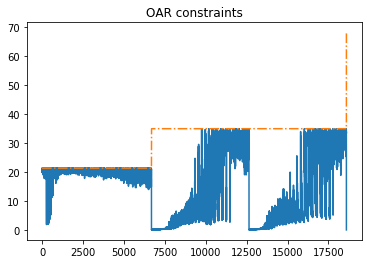

In [13]:
#Constraints mult
plt.plot(optimization_tools.constraints_all(u_mult_dv, updated_H, updated_gamma, updated_D, updated_C, tol = 0.05, verbose = 0)['Constr at u_opt'])
plt.plot(optimization_tools.constraints_all(u_mult_dv, updated_H, updated_gamma, updated_D, updated_C, tol = 0.05, verbose = 0)['actual constr'], '-.')
plt.title('OAR constraints')

Text(0.5, 1.0, 'OAR constraints')

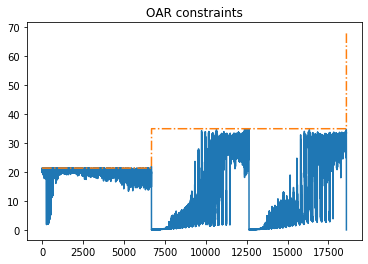

In [14]:
#Constraints conv
plt.plot(optimization_tools.constraints_all(u_conv_dv, updated_H_conv, updated_gamma_conv, updated_D_conv, updated_C_conv, tol = 0.05, verbose = 0)['Constr at u_opt'])
plt.plot(optimization_tools.constraints_all(u_conv_dv, updated_H_conv, updated_gamma_conv, updated_D_conv, updated_C_conv, tol = 0.05, verbose = 0)['actual constr'], '-.')
plt.title('OAR constraints')

In [15]:
len_voxels = data['Aphoton'].shape[0]
beamlet_indices = np.split(np.arange(len_voxels), np.cumsum(np.squeeze(data['num_beamlets'])))[:-1] 

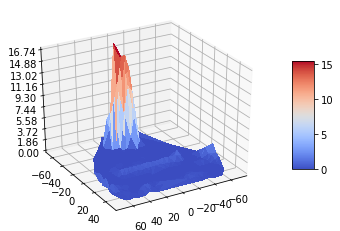

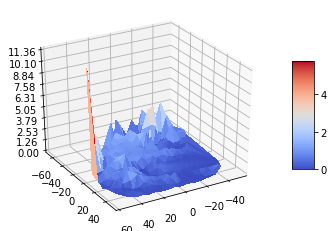

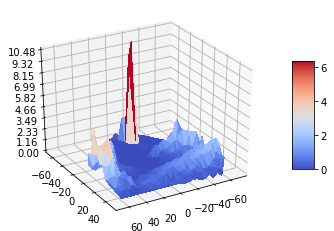

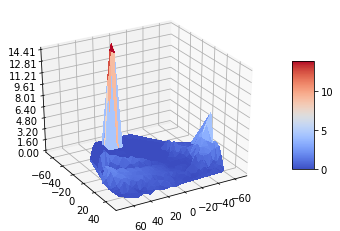

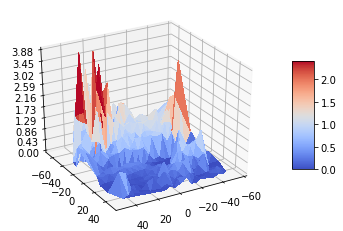

In [16]:
%matplotlib inline
for i in range(5):
    x_beam = data['beamlet_pos'][beamlet_indices[i]][:,0]
    y_beam = data['beamlet_pos'][beamlet_indices[i]][:,1]
    u_beam = u_mult_dv[:2289][beamlet_indices[i]]
    evaluation.plot_beam(x_beam, y_beam, u_beam)

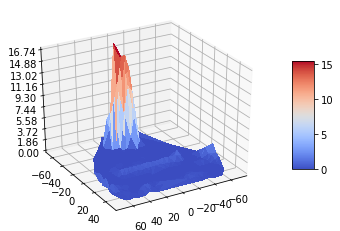

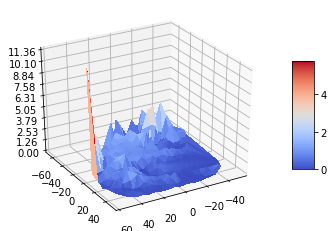

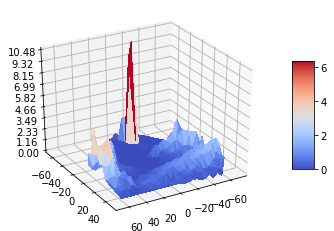

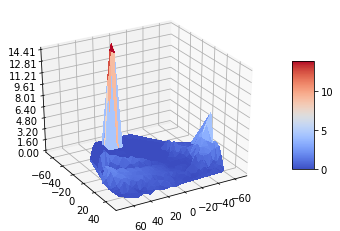

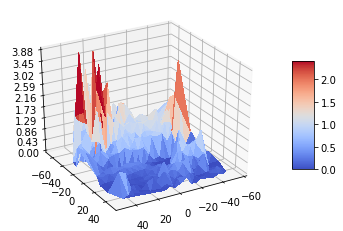

In [17]:
%matplotlib inline
for i in range(5):
    x_beam = data['beamlet_pos'][beamlet_indices[i]][:,0]
    y_beam = data['beamlet_pos'][beamlet_indices[i]][:,1]
    u_beam = u_conv_dv[:2289][beamlet_indices[i]]
    evaluation.plot_beam(x_beam, y_beam, u_beam)

In [149]:
scipy.stats.describe([0,1,2])

3

In [156]:
def min_max_mean_df(list_of_doses_and_names, dose_type = '_BE'):
    """list_of_doses_and_names should be a list of tuples"""
    df_list = [[i[0], np.min(i[1]), np.max(i[1]), np.mean(i[1])] for i in list_of_doses_and_names]
    df_cols = ['Organ', 'min'+dose_type, 'max'+dose_type, 'mean'+dose_type]
    df = pd.DataFrame(df_list, columns=df_cols)
    return df

In [188]:
d_Target, DV_fractions_Target, organ_BE_Target, organ_photon_dose_Target, organ_proton_dose_Target, organ_photon_BE_Target, organ_proton_BE_Target = evaluation.evaluation_function(u_mult_dv, [43,1], data, 'Target', Alpha, Beta, Gamma, Delta, 100, resolution = 500)
d_LFemur, DV_fractions_LFemur, organ_BE_LFemur, organ_photon_dose_LFemur, organ_proton_dose_LFemur, organ_photon_BE_LFemur, organ_proton_BE_LFemur = evaluation.evaluation_function(u_mult_dv, [43,1], data, 'L Femur', Alpha, Beta, Gamma, Delta, 100, resolution = 500)
d_RFemur, DV_fractions_RFemur, organ_BE_RFemur, organ_photon_dose_RFemur, organ_proton_dose_RFemur, organ_photon_BE_RFemur, organ_proton_BE_RFemur = evaluation.evaluation_function(u_mult_dv, [43,1], data, 'R Femur', Alpha, Beta, Gamma, Delta, 100, resolution = 500)
d_Rectum, DV_fractions_Rectum, organ_BE_Rectum, organ_photon_dose_Rectum, organ_proton_dose_Rectum, organ_photon_BE_Rectum, organ_proton_BE_Rectum = evaluation.evaluation_function(u_mult_dv, [43,1], data, 'Rectum', Alpha, Beta, Gamma, Delta, 100, resolution = 500)
d_Bladder, DV_fractions_Bladder, organ_BE_Bladder, organ_photon_dose_Bladder, organ_proton_dose_Bladder, organ_photon_BE_Bladder, organ_proton_BE_Bladder = evaluation.evaluation_function(u_mult_dv, [43,1], data, 'Bladder', Alpha, Beta, Gamma, Delta, 100, resolution = 500)

In [189]:
# updated_C
list_of_doses_and_names = [['Target', organ_BE_Target],['L Femur', organ_BE_LFemur], ['R Femur', organ_BE_RFemur], ['Rectum', organ_BE_Rectum], ['Bladder', organ_BE_Bladder]]
df_BE = min_max_mean_df(list_of_doses_and_names, dose_type = '_BE')


     Organ     min_BE       max_BE     mean_BE
0   Target  15.362906  2915.159511  105.931977
1  L Femur   0.035995    35.004318   12.891762
2  R Femur   0.019875    35.004016   13.107031
3   Rectum   1.860090   335.384198   37.774627
4  Bladder   2.873362   863.846749   21.391991


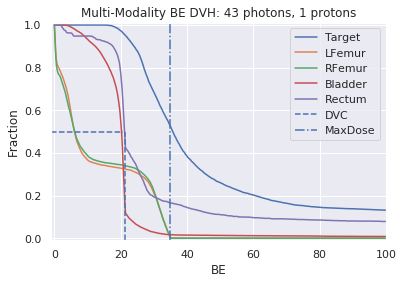

In [190]:
sns.set()
plt.plot(d_Target, DV_fractions_Target, label = 'Target')
plt.plot(d_LFemur, DV_fractions_LFemur, label = 'LFemur')
plt.plot(d_RFemur, DV_fractions_RFemur, label = 'RFemur')
plt.plot(d_Bladder, DV_fractions_Bladder, label = 'Bladder')
plt.plot(d_Rectum, DV_fractions_Rectum, label = 'Rectum')
plt.ylim(ymin=-0.01, ymax = 1.01)
plt.xlim(xmin=-1, xmax = 100)
# plt.plot((-1, 21.38), (0.5, 0.5), 'k-')
#dv constr
plt.axvline(21.38, 0, 0.5, ls = '--', c='b')
plt.axhline(0.5, xmin = 0, xmax = 0.2138, ls = '--', c='b', label = 'DVC')
#max dose cnstr
plt.axvline(35, 0, 1, ls = '-.', c='b', label = 'MaxDose')
# plt.axhline(0.5, xmin = 0, xmax = 0.35, ls = '--', c='b')
plt.legend()
# plt.xlabel('Gy')

print()
plt.ylabel('Fraction')
plt.xlabel('BE')
plt.title('Multi-Modality BE DVH: 43 photons, 1 protons')
print(df_BE)

In [191]:
def dose_dvh(max_BE, resolution, organ_BE):
    BE_levels = np.linspace(0, max_BE, resolution)
    #Now for each BE level find the fraction of voxels that are <=
    DV_fractions = []
    for BE_level in BE_levels:
        DV_fraction = np.sum(organ_BE >= BE_level)/len(organ_BE)
        DV_fractions.append(DV_fraction)
    return BE_levels, DV_fractions

In [192]:
max_BE = 5.0
resolution = 500
d_Target, DV_fractions_Target = dose_dvh(max_BE, resolution, organ_photon_dose_Target)
d_LFemur, DV_fractions_LFemur = dose_dvh(max_BE, resolution, organ_photon_dose_LFemur)
d_RFemur, DV_fractions_RFemur = dose_dvh(max_BE, resolution, organ_photon_dose_RFemur)
d_Bladder, DV_fractions_Bladder = dose_dvh(max_BE, resolution, organ_photon_dose_Bladder)
d_Rectum, DV_fractions_Rectum = dose_dvh(max_BE, resolution, organ_photon_dose_Rectum)

list_of_doses_and_names = [['Target', organ_photon_dose_Target],['L Femur', organ_photon_dose_LFemur], ['R Femur', organ_photon_dose_RFemur], ['Rectum', organ_photon_dose_Rectum], ['Bladder', organ_photon_dose_Bladder]]
df_BE = min_max_mean_df(list_of_doses_and_names, dose_type = '_Photon_Dose')

     Organ  min_Photon_Dose  max_Photon_Dose  mean_Photon_Dose
0   Target         0.689948        18.693271          2.080608
1  L Femur         0.002389         1.370189          0.535862
2  R Femur         0.001320         1.375934          0.541196
3   Rectum         0.120681         8.311144          1.585236
4  Bladder         0.184140        14.597968          1.079528


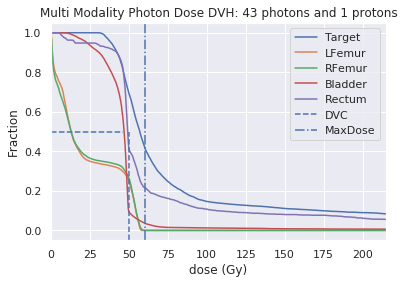

In [194]:
sns.set()
plt.plot(43*d_Target, DV_fractions_Target, label = 'Target')
plt.plot(43*d_LFemur, DV_fractions_LFemur, label = 'LFemur')
plt.plot(43*d_RFemur, DV_fractions_RFemur, label = 'RFemur')
plt.plot(43*d_Bladder, DV_fractions_Bladder, label = 'Bladder')
plt.plot(43*d_Rectum, DV_fractions_Rectum, label = 'Rectum')
# plt.ylim(ymin=0, ymax = 1.0)
plt.xlim(xmin=0, xmax = 43*5)

plt.axvline(50, 0, 0.5, ls = '--', c='b')
plt.axhline(0.5, xmin = 0, xmax = 0.2138, ls = '--', c='b', label = 'DVC')

plt.axvline(60, 0, 1, ls = '-.', c='b', label = 'MaxDose')

plt.legend()
# plt.xlabel('Gy')
plt.ylabel('Fraction')
plt.xlabel('dose (Gy)')
plt.title('Multi Modality Photon Dose DVH: 43 photons and 1 protons')
print(df_BE)

In [195]:
max_BE = 5.0
resolution = 500
d_Target, DV_fractions_Target = dose_dvh(max_BE, resolution, organ_proton_dose_Target)
d_LFemur, DV_fractions_LFemur = dose_dvh(max_BE, resolution, organ_proton_dose_LFemur)
d_RFemur, DV_fractions_RFemur = dose_dvh(max_BE, resolution, organ_proton_dose_RFemur)
d_Bladder, DV_fractions_Bladder = dose_dvh(max_BE, resolution, organ_proton_dose_Bladder)
d_Rectum, DV_fractions_Rectum = dose_dvh(max_BE, resolution, organ_proton_dose_Rectum)

list_of_doses_and_names = [['Target', organ_proton_dose_Target],['L Femur', organ_proton_dose_LFemur], ['R Femur', organ_proton_dose_RFemur], ['Rectum', organ_proton_dose_Rectum], ['Bladder', organ_proton_dose_Bladder]]
df_BE = min_max_mean_df(list_of_doses_and_names, dose_type = '_Proton_Dose')

     Organ  min_Proton_Dose  max_Proton_Dose  mean_Proton_Dose
0   Target         0.511767         4.450148          2.766389
1  L Femur         0.000000         2.606951          1.200999
2  R Femur         0.000000         2.631220          1.178571
3   Rectum         0.000000         4.347759          0.805590
4  Bladder         0.000000         4.264179          0.632141


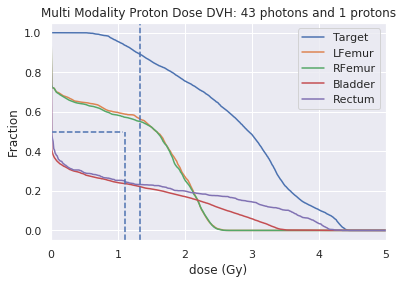

In [172]:
sns.set()
plt.plot(d_Target, DV_fractions_Target, label = 'Target')
plt.plot(d_LFemur, DV_fractions_LFemur, label = 'LFemur')
plt.plot(d_RFemur, DV_fractions_RFemur, label = 'RFemur')
plt.plot(d_Bladder, DV_fractions_Bladder, label = 'Bladder')
plt.plot(d_Rectum, DV_fractions_Rectum, label = 'Rectum')
# plt.ylim(ymin=0, ymax = 1.0)
plt.xlim(xmin=0, xmax = 5)

#DVC:
plt.axvline(50/45, 0, 0.5, ls = '--', c='b')
plt.axhline(0.5, xmin = 0, xmax = 0.2138, ls = '--', c='b')

#Max dose:
plt.axvline(60/45, 0, 1, ls = '--', c='b')

plt.legend()
# plt.xlabel('Gy')
plt.ylabel('Fraction')
plt.xlabel('dose (Gy)')
plt.title('Multi Modality Proton Dose DVH: 43 photons and 1 protons')
print(df_BE)

In [198]:
max_BE = 45*5.0
resolution = 500
d_Target, DV_fractions_Target = dose_dvh(max_BE, resolution, 43*organ_photon_dose_Target + 1*organ_proton_dose_Target)
d_LFemur, DV_fractions_LFemur = dose_dvh(max_BE, resolution, 43*organ_photon_dose_LFemur + 1*organ_proton_dose_LFemur)
d_RFemur, DV_fractions_RFemur = dose_dvh(max_BE, resolution, 43*organ_photon_dose_RFemur + 1*organ_proton_dose_RFemur)
d_Bladder, DV_fractions_Bladder = dose_dvh(max_BE, resolution, 43*organ_photon_dose_Bladder + 1*organ_proton_dose_Bladder)
d_Rectum, DV_fractions_Rectum = dose_dvh(max_BE, resolution, 43*organ_photon_dose_Rectum + 1*organ_proton_dose_Rectum)

list_of_doses_and_names = [['Target', organ_photon_dose_Target + organ_proton_dose_Target],
                           ['L Femur', organ_photon_dose_LFemur + organ_proton_dose_LFemur], 
                           ['R Femur', organ_photon_dose_RFemur +  organ_proton_dose_RFemur],
                           ['Rectum', organ_photon_dose_Rectum + organ_proton_dose_Rectum], 
                           ['Bladder', organ_photon_dose_Bladder + organ_proton_dose_Bladder]]
df_BE = min_max_mean_df(list_of_doses_and_names, dose_type = '_Photon+Proton_Dose')

     Organ  min_Photon+Proton_Dose  max_Photon+Proton_Dose  \
0   Target                1.255431               22.751242   
1  L Femur                0.002389                3.923221   
2  R Femur                0.001320                3.899822   
3   Rectum                0.120681               12.171417   
4  Bladder                0.184140               18.808147   

   mean_Photon+Proton_Dose  
0                 4.846998  
1                 1.736861  
2                 1.719767  
3                 2.390826  
4                 1.711669  


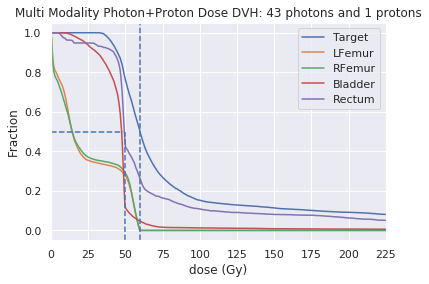

In [200]:
sns.set()
plt.plot(d_Target, DV_fractions_Target, label = 'Target')
plt.plot(d_LFemur, DV_fractions_LFemur, label = 'LFemur')
plt.plot(d_RFemur, DV_fractions_RFemur, label = 'RFemur')
plt.plot(d_Bladder, DV_fractions_Bladder, label = 'Bladder')
plt.plot(d_Rectum, DV_fractions_Rectum, label = 'Rectum')

#plt.ylim(ymin=0, ymax = 1.0)
plt.xlim(xmin=0, xmax = 45*5)

#DVC:
plt.axvline(50, 0, 0.5, ls = '--', c='b')
plt.axhline(0.5, xmin = 0, xmax = 0.2138, ls = '--', c='b')

#Max dose:
plt.axvline(60, 0, 1, ls = '--', c='b')

plt.legend()
# plt.xlabel('Gy')
plt.ylabel('Fraction')
plt.xlabel('dose (Gy)')
plt.title('Multi Modality Photon+Proton Dose DVH: 43 photons and 1 protons')
print(df_BE)

In [ ]:
# BE_levels, DV_fractions, organ_BE, organ_photon_dose, organ_photon_BE

In [177]:
d_Target, DV_fractions_Target, organ_BE_Target, organ_photon_dose_Target, organ_photon_BE_Target = evaluation.evaluation_function_photon(u_conv_dv, [43,0], data, 'Target', Alpha, Beta, Gamma, Delta, 100, resolution = 500)
d_LFemur, DV_fractions_LFemur, organ_BE_LFemur, organ_photon_dose_LFemur, organ_photon_BE_LFemur = evaluation.evaluation_function_photon(u_conv_dv, [43,0], data, 'L Femur', Alpha, Beta, Gamma, Delta, 100, resolution = 500)
d_RFemur, DV_fractions_RFemur, organ_BE_RFemur, organ_photon_dose_RFemur, organ_photon_BE_RFemur = evaluation.evaluation_function_photon(u_conv_dv, [43,0], data, 'R Femur', Alpha, Beta, Gamma, Delta, 100, resolution = 500)
d_Rectum, DV_fractions_Rectum, organ_BE_Rectum, organ_photon_dose_Rectum, organ_photon_BE_Rectum = evaluation.evaluation_function_photon(u_conv_dv, [43,0], data, 'Rectum', Alpha, Beta, Gamma, Delta, 100, resolution = 500)
d_Bladder, DV_fractions_Bladder, organ_BE_Bladder, organ_photon_dose_Bladder, organ_photon_BE_Bladder = evaluation.evaluation_function_photon(u_mult_dv, [43,0], data, 'Bladder', Alpha, Beta, Gamma, Delta, 100, resolution = 500)

organ_BE:  [ 68.66248741  85.96437887 109.31484437 ...  17.6065379   17.0664191
  17.02114018]
organ_photon_BE:  [ 68.66248741  85.96437887 109.31484437 ...  17.6065379   17.0664191
  17.02114018]
organ_BE:  [ 0.10357546  0.08935095  0.07973376 ... 33.70700278 31.3303516
 28.83282819]
organ_photon_BE:  [ 0.10357546  0.08935095  0.07973376 ... 33.70700278 31.3303516
 28.83282819]
organ_BE:  [ 0.05635289  0.04074439  0.12529868 ... 30.24277433 33.18307953
 34.95410414]
organ_photon_BE:  [ 0.05635289  0.04074439  0.12529868 ... 30.24277433 33.18307953
 34.95410414]
organ_BE:  [ 2.25772244  1.92876212  1.86008953 ... 21.28021772 21.24598998
 18.69559882]
organ_photon_BE:  [ 2.25772244  1.92876212  1.86008953 ... 21.28021772 21.24598998
 18.69559882]
organ_BE:  [844.88696729 861.13239389 719.90349844 ...   4.27132827   4.32662798
   4.29307766]
organ_photon_BE:  [844.88696729 861.13239389 719.90349844 ...   4.27132827   4.32662798
   4.29307766]


In [178]:
# updated_C
list_of_doses_and_names = [['Target', organ_BE_Target],['L Femur', organ_BE_LFemur], ['R Femur', organ_BE_RFemur], ['Rectum', organ_BE_Rectum], ['Bladder', organ_BE_Bladder]]
df_BE = min_max_mean_df(list_of_doses_and_names, dose_type = '_BE')


     Organ     min_BE       max_BE     mean_BE
0   Target  13.965823  2910.857511  103.460654
1  L Femur   0.035995    34.748914   12.067399
2  R Femur   0.019875    34.954104   12.299685
3   Rectum   1.860090   332.998849   37.318110
4  Bladder   2.873362   861.132394   21.062743


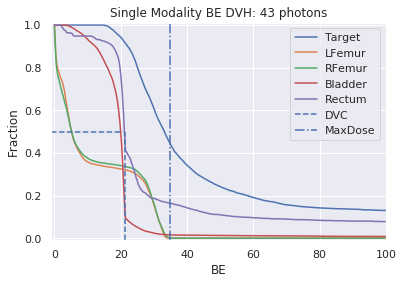

In [180]:
sns.set()
plt.plot(d_Target, DV_fractions_Target, label = 'Target')
plt.plot(d_LFemur, DV_fractions_LFemur, label = 'LFemur')
plt.plot(d_RFemur, DV_fractions_RFemur, label = 'RFemur')
plt.plot(d_Bladder, DV_fractions_Bladder, label = 'Bladder')
plt.plot(d_Rectum, DV_fractions_Rectum, label = 'Rectum')
plt.ylim(ymin=-0.01, ymax = 1.01)
plt.xlim(xmin=-1, xmax = 100)
# plt.plot((-1, 21.38), (0.5, 0.5), 'k-')
#dv constr
plt.axvline(21.38, 0, 0.5, ls = '--', c='b')
plt.axhline(0.5, xmin = 0, xmax = 0.2138, ls = '--', c='b', label = 'DVC')
#max dose cnstr
plt.axvline(35, 0, 1, ls = '-.', c='b', label = 'MaxDose')
# plt.axhline(0.5, xmin = 0, xmax = 0.35, ls = '--', c='b')
plt.legend()
# plt.xlabel('Gy')

print()
plt.ylabel('Fraction')
plt.xlabel('BE')
plt.title('Single Modality BE DVH: 43 photons')
print(df_BE)

In [181]:
max_BE = 5.0
resolution = 500
d_Target, DV_fractions_Target = dose_dvh(max_BE, resolution, organ_photon_dose_Target)
d_LFemur, DV_fractions_LFemur = dose_dvh(max_BE, resolution, organ_photon_dose_LFemur)
d_RFemur, DV_fractions_RFemur = dose_dvh(max_BE, resolution, organ_photon_dose_RFemur)
d_Bladder, DV_fractions_Bladder = dose_dvh(max_BE, resolution, organ_photon_dose_Bladder)
d_Rectum, DV_fractions_Rectum = dose_dvh(max_BE, resolution, organ_photon_dose_Rectum)

list_of_doses_and_names = [['Target', organ_photon_dose_Target],['L Femur', organ_photon_dose_LFemur], ['R Femur', organ_photon_dose_RFemur], ['Rectum', organ_photon_dose_Rectum], ['Bladder', organ_photon_dose_Bladder]]
df_BE = min_max_mean_df(list_of_doses_and_names, dose_type = '_Photon_Dose')

     Organ  min_Photon_Dose  max_Photon_Dose  mean_Photon_Dose
0   Target         0.689948        18.693271          2.080608
1  L Femur         0.002389         1.370189          0.535862
2  R Femur         0.001320         1.375934          0.541196
3   Rectum         0.120681         8.311145          1.585236
4  Bladder         0.184140        14.597968          1.079528


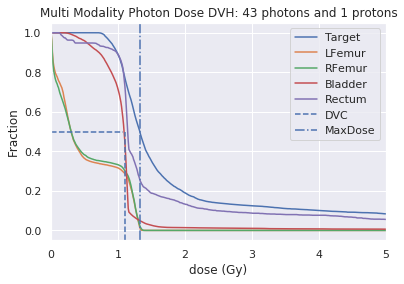

In [182]:
sns.set()
plt.plot(d_Target, DV_fractions_Target, label = 'Target')
plt.plot(d_LFemur, DV_fractions_LFemur, label = 'LFemur')
plt.plot(d_RFemur, DV_fractions_RFemur, label = 'RFemur')
plt.plot(d_Bladder, DV_fractions_Bladder, label = 'Bladder')
plt.plot(d_Rectum, DV_fractions_Rectum, label = 'Rectum')
# plt.ylim(ymin=0, ymax = 1.0)
plt.xlim(xmin=0, xmax = 5)

plt.axvline(50/45, 0, 0.5, ls = '--', c='b')
plt.axhline(0.5, xmin = 0, xmax = 0.2138, ls = '--', c='b', label = 'DVC')

plt.axvline(60/45, 0, 1, ls = '-.', c='b', label = 'MaxDose')

plt.legend()
# plt.xlabel('Gy')
plt.ylabel('Fraction')
plt.xlabel('dose (Gy)')
plt.title('Multi Modality Photon Dose DVH: 43 photons and 1 protons')
print(df_BE)